# Solving Poisson equation using FEM + Simple adaptive method


In the following notebook one will solve the Poisson equation in 2D using FEM and global adaptive grid method

The code runs an adaptive refinement loop for up to max_iter iterations. At each iteration, the finite element space is rebuilt on the current mesh, and the problem is solved. The maximum error between the FE solution and the analytical solution is computed on a fixed grid. If the maximum error exceeds the tolerance tol, the mesh is uniformly refined by doubling the number of cells in each direction. Otherwise, the loop stops. I chose very rough grid to show the refinement algorithm in work. However, this is the algorithm which is not working in local terms but works with the global maximal error. To proceed to the real 

To start with, we upload required packages

In [1]:
using Gridap, Plots

Then we define the domain and initial mesh

In [2]:
domain = (-3, 3, -3, 3)
n_cells = (10, 10)  # initial mesh resolution
model = CartesianDiscreteModel(domain, n_cells)

CartesianDiscreteModel()

Subsequently, we define the problem parameters and analytical solution

In [3]:
order = 2
# Right-hand side function: f(x,y) = 4*(x^2+y^2-1)*exp(-x^2-y^2)
f(x) = 4 * ((x[1]^2 + x[2]^2) - 1) * exp(-x[1]^2 - x[2]^2)
# Analytical solution: u(x,y)=exp(-x^2-y^2)
u_exact(x) = exp(-x[1]^2 - x[2]^2)

u_exact (generic function with 1 method)

After that, the adaptive loop paramters are set up.

Note: When I adjusted max_iter to 10 I thought my laptop will explode during main algorithm compilation(15.2 Gb of RAM was used after iteration 7) so I left this number to 5 because iteration 6 and 7 didn't provide better result.

In [4]:
tol = 1e-4        # tolerance for maximum error
max_iter = 5      # maximum number of refinement iterations
uh = nothing      # to store the FE solution

Then we solve and refine(if needed) our grid. Here is the whole algorithm.

In [5]:
for iter in 1:max_iter
    # Define the FE space on the current mesh
    reffe = ReferenceFE(lagrangian, Float64, order)
    V = FESpace(model, reffe; conformity=:H1, dirichlet_tags="boundary")
    
    # Define the integration measure
    Ω = Triangulation(model)
    dΩ = Measure(Ω, 2)
    
    # Define the weak form with the specified formulation:
    a(u,v) = (-1)*∫( ∇(u) ⋅ ∇(v) )dΩ
    l(v)   =  ∫( f * v )dΩ
    
    # Assemble and solve the FE problem
    op = AffineFEOperator(a, l, V, V)
    uh = solve(op)
    
    # Evaluate the error on a fixed grid and generate a Point(x, y) for each 𝑦 in ys and each 𝑥 in xs.
    n = 10
    xs = range(-3, 3, length=n)
    ys = range(-3, 3, length=n)
    points = [Point(x, y) for y in ys, x in xs]
    
    # Compute the maximum error on the grid
    error_values = [abs(uh(p) - u_exact(p)) for p in points]
    max_error = maximum(error_values)
    println("Iteration $iter: max error = $max_error")
    
    # If the maximum error is below tolerance, stop the refinement loop
    if max_error < tol
        break
    else
        # Uniform refinement: double the number of cells in each direction
        n_cells = (n_cells[1]*2, n_cells[2]*2)
        model = CartesianDiscreteModel(domain, n_cells)
    end
end

Iteration 1: max error = 0.0033998883214026443
Iteration 2: max error = 0.001124332599314437
Iteration 3: max error = 0.00022524492783837502
Iteration 4: max error = 0.00011043194477712001
Iteration 5: max error = 0.00011043194477712004


Now we evaluate the final solution and compute error for plotting

In [6]:
n = 60
xs = range(-3, 3, length=n)
ys = range(-3, 3, length=n)
points = [Point(x, y) for y in ys, x in xs]

uh_values = [uh(p) for p in points]
u_exact_values = [u_exact(p) for p in points]

60×60 Matrix{Float64}:
 1.523e-8    2.7746e-8   4.95131e-8  …  4.95131e-8  2.7746e-8   1.523e-8
 2.7746e-8   5.05479e-8  9.02032e-8     9.02032e-8  5.05479e-8  2.7746e-8
 4.95131e-8  9.02032e-8  1.60969e-7     1.60969e-7  9.02032e-8  4.95131e-8
 8.65479e-8  1.57673e-7  2.8137e-7      2.8137e-7   1.57673e-7  8.65479e-8
 1.48187e-7  2.69968e-7  4.8176e-7      4.8176e-7   2.69968e-7  1.48187e-7
 2.48531e-7  4.52775e-7  8.07981e-7  …  8.07981e-7  4.52775e-7  2.48531e-7
 4.08289e-7  7.43823e-7  1.32736e-6     1.32736e-6  7.43823e-7  4.08289e-7
 6.57011e-7  1.19695e-6  2.13596e-6     2.13596e-6  1.19695e-6  6.57011e-7
 1.03561e-6  1.88667e-6  3.36679e-6     3.36679e-6  1.88667e-6  1.03561e-6
 1.59895e-6  2.91297e-6  5.19823e-6     5.19823e-6  2.91297e-6  1.59895e-6
 2.41819e-6  4.40547e-6  7.86161e-6  …  7.86161e-6  4.40547e-6  2.41819e-6
 3.58232e-6  6.52629e-6  1.16462e-5     1.16462e-5  6.52629e-6  3.58232e-6
 5.19823e-6  9.47015e-6  1.68996e-5     1.68996e-5  9.47015e-6  5.19823e-6
 ⋮   

Here we reshaping our solution into matrix for plotting

In [7]:
uh_matrix = reshape(uh_values, (n, n))
u_exact_matrix = reshape(u_exact_values, (n, n))
error_matrix = abs.(uh_matrix .- u_exact_matrix)

60×60 Matrix{Float64}:
 1.523e-8    2.7746e-8   4.95131e-8  …  4.95131e-8  2.7746e-8   1.523e-8
 2.7746e-8   4.1689e-7   8.06017e-7     8.06017e-7  4.1689e-7   2.7746e-8
 4.95131e-8  8.06017e-7  1.55371e-6     1.55371e-6  8.06017e-7  4.95131e-8
 8.65479e-8  1.20447e-6  2.30173e-6     2.30173e-6  1.20447e-6  8.65479e-8
 1.48187e-7  1.62442e-6  3.06328e-6     3.06328e-6  1.62442e-6  1.48187e-7
 2.48531e-7  2.08284e-6  3.85671e-6  …  3.85671e-6  2.08284e-6  2.48531e-7
 4.08289e-7  2.60309e-6  4.70645e-6     4.70645e-6  2.60309e-6  4.08289e-7
 6.57011e-7  3.21649e-6  5.64391e-6     5.64391e-6  3.21649e-6  6.57011e-7
 1.03561e-6  3.96397e-6  6.70857e-6     6.70857e-6  3.96397e-6  1.03561e-6
 1.59895e-6  4.89758e-6  7.94855e-6     7.94855e-6  4.89758e-6  1.59895e-6
 2.41819e-6  6.08139e-6  9.42044e-6  …  9.42044e-6  6.08139e-6  2.41819e-6
 3.58232e-6  7.59187e-6  1.11891e-5     1.11891e-5  7.59187e-6  3.58232e-6
 5.19823e-6  9.51728e-6  1.33268e-5     1.33268e-5  9.51728e-6  5.19823e-6
 ⋮   

Eventually, we plot our results

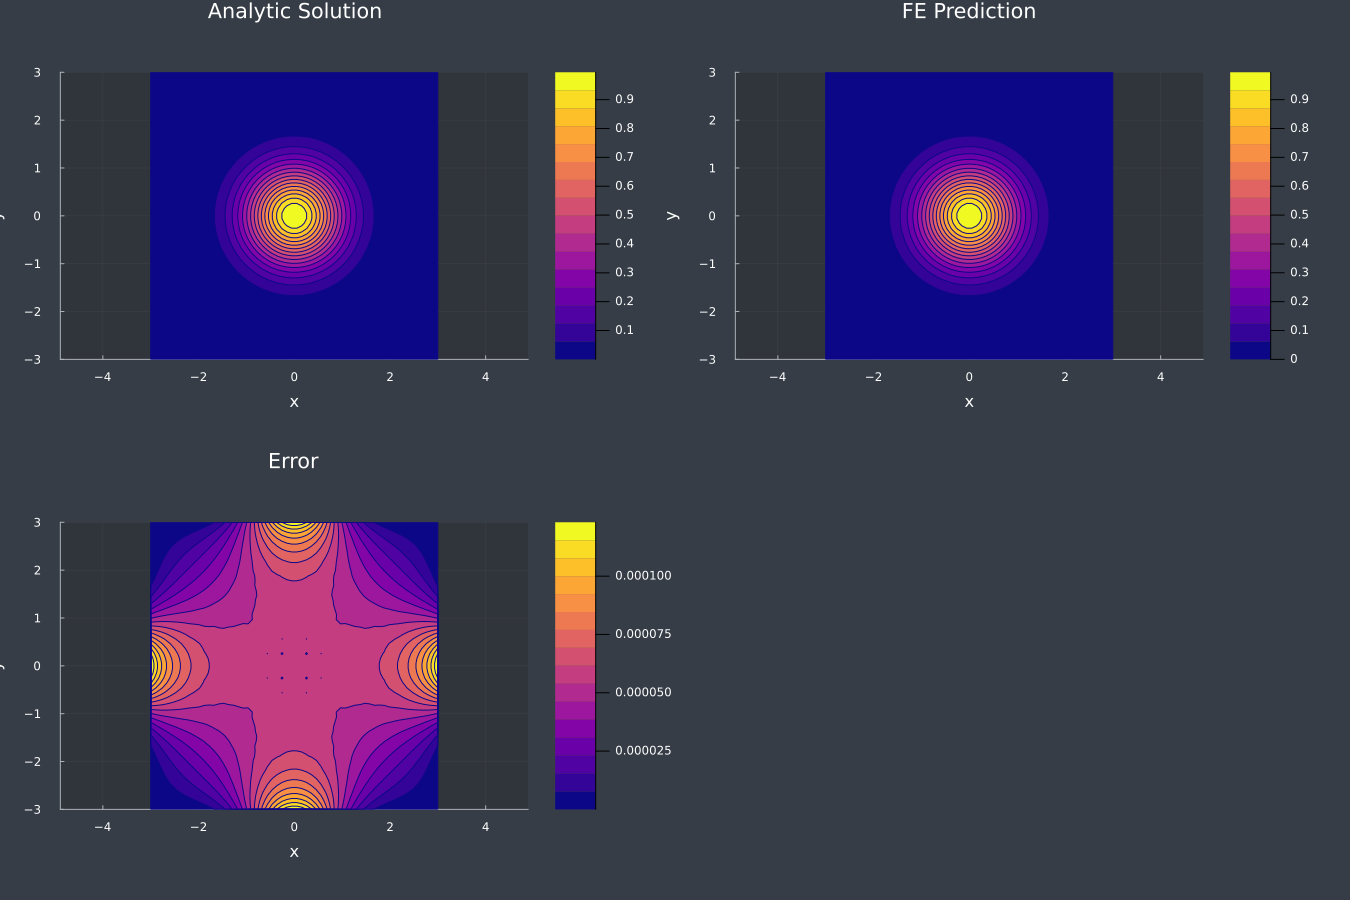

In [8]:
theme(:dark)

p1 = contour(xs, ys, u_exact_matrix;
    fill         = true,
    c            = :plasma,
    colorbar     = true,
    title        = "Analytic Solution",
    xlabel       = "x",
    ylabel       = "y",
    aspect_ratio = :equal,
    levels       = 15,
)

p2 = contour(xs, ys, uh_matrix;
    fill         = true,
    c            = :plasma,
    colorbar     = true,
    title        = "FE Prediction",
    xlabel       = "x",
    ylabel       = "y",
    aspect_ratio = :equal,
    levels       = 15,
)

p3 = contour(xs, ys, error_matrix;
    fill         = true,
    c            = :plasma,
    colorbar     = true,
    title        = "Error",
    xlabel       = "x",
    ylabel       = "y",
    aspect_ratio = :equal,
    levels       = 15,
)
plot(p1, p2, p3, layout = (2, 2), size = (1350, 900))
